<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h1> Bachelor Thesis Figures</h1>
</div>
<div style="text-align: justified; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <p> This notebook is devoted to creating beautiful figures for my bachelor thesis. The code is inspired by this repo <a href="https://github.com/AndreyChurkin/BeautifulFigures/">BeautifulFigures</a>. I made my original figures in Mathematica, but it mos certainly is not a good environment for scientific figures. 
    </p>
</div>

In [34]:
# Import Libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scienceplots
import pandas as pd
import numpy as np

In [63]:
# Font settings and style
plt.rcParams.update({
    'font.family': 'Courier New',   
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
    
    # Ensure math uses the same font
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Courier New',
    'mathtext.it': 'Courier New:italic',
    'mathtext.bf': 'Courier New:bold',
})

# Colout palette
my_palette = ["#d1cbe5", "#9671bd", "#6a408d", "#77b5b6", "#378d94"]

In [64]:
# Define the data directory and the data files
# 400K data
data_400K = "../cluster-files/ml-400k/"

# 300K data
data_300K = "../cluster-files/ml-300k/"

# ML Transferibility data
data_thermal = "../cluster-files/thermal-coeff/"

# Relaxation files 
data_relaxation = "../dftb/"

# Number of atoms
n_atoms = 690

<div class="header" style="text-align: center; margin-top: 20px; margin-bottom: 20px; font-family: Arial, sans-serif;">
    <h2> K-points analysis DFTB+ </h2>

In [58]:
# Kpoints data
dftb_kpoints = data_relaxation + "kp.dat"

# Read the kpoints data
dftb_kp = pd.read_csv(dftb_kpoints, header = None, sep = '\s+')

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_334977/4068961255.py:5: SyntaxWarning: invalid escape sequence '\s'
  dftb_kp = pd.read_csv(dftb_kpoints, header = None, sep = '\s+')


In [59]:
# Define the X and Y values for the plot
x_kp = [0.06, 0.04, 0.03]
y_kp = dftb_kp[1].values / n_atoms

In [60]:
y_kp

array([-6.75432455, -6.75436524, -6.75436305])

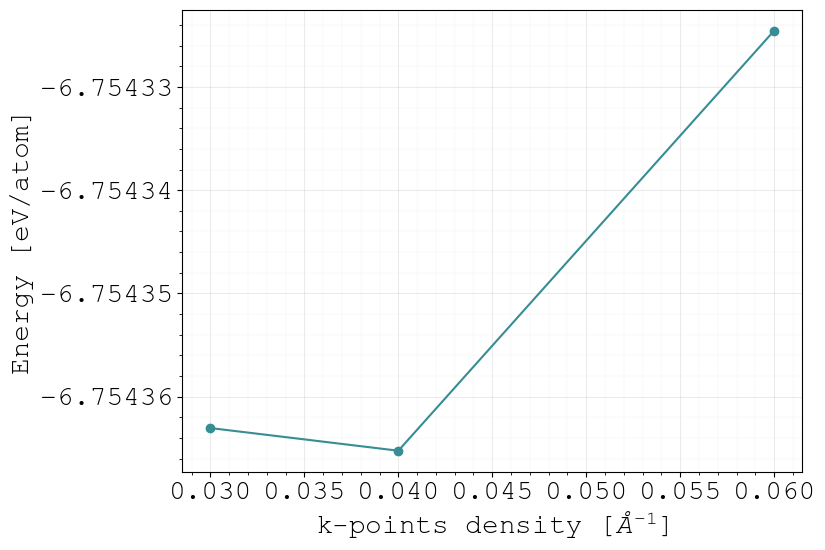

In [68]:
# Plot the kpoints 
fig, ax = plt.subplots(figsize=(8, 6))
ax.ticklabel_format(style='plain')
# Disable scientific and offset notation
formatter = ScalarFormatter(useOffset=False, useMathText=False)
formatter.set_scientific(False)

ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.plot(x_kp, y_kp, marker='o', linestyle='-', color=my_palette[4], label='DFTB+ Kpoints')


# Set the x and y labels
ax.set(xlabel= r"k-points density [$\AA^{-1}$]", ylabel='Energy [eV/atom]')
# Set the title
#ax.set_title('DFTB+ Kpoints vs Energy per Atom')
# Set the x and y limits
#ax.set_xlim(0, 0.07)
#ax.set_ylim(0, 0.1)
# Add a grid

# Major grid:
ax.grid(True, which='major', linestyle='-', linewidth=0.75, alpha=0.25)

ax.set_axisbelow(True) # <-- Ensure grid is below data

# Minor ticks and grid:
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='-', linewidth=0.25, alpha=0.15)
plt.show()

In [51]:
okabe_ito = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#000000"   # black
]
material = [
    "#e53935", "#8e24aa", "#3949ab", "#1e88e5",
    "#43a047", "#fdd835", "#fb8c00", "#6d4c41"
]

nord = ["#5E81AC", "#88C0D0", "#A3BE8C", "#EBCB8B", "#BF616A"]

my_palette = ["#d1cbe5", "#9671bd", "#6a408d", "#77b5b6", "#378d94"]

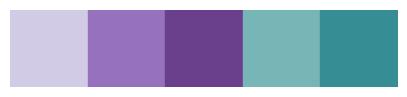

In [52]:
import matplotlib.pyplot as plt

def show_palette(colors):
    fig, ax = plt.subplots(figsize=(len(colors), 1))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis("off")
    plt.show()

show_palette(my_palette)
